# 02 - Vocabulary Building and Data Loading

## Learning Objectives
- Build vocabulary from cleaned text data
- Create efficient PyTorch data loaders
- Implement text-to-sequence conversion
- Handle variable-length sequences
- Understand PyTorch Dataset and DataLoader concepts

## Phase 1: PyTorch Fundamentals 🧠
*Build everything from scratch to understand the foundations*

## Phase 2: Transformers Enhancement 🚀
*Enhance with modern NLP tools after mastering fundamentals*

---

## Overview

In this notebook, you'll build the data pipeline that converts your cleaned text into numerical sequences that PyTorch models can process. This involves:

1. **Vocabulary Building**: Creating word-to-index mappings
2. **Text-to-Sequence Conversion**: Converting text to numerical sequences
3. **PyTorch Dataset**: Creating custom dataset classes
4. **Data Loading**: Implementing efficient data loaders with batching
5. **Pipeline Validation**: Testing and optimizing your data pipeline

## Prerequisites

Make sure you have completed:
- ✅ `00_exploration.ipynb` - Data exploration and EDA
- ✅ `01_preprocessing.ipynb` - Text cleaning and preprocessing

You'll be working with the cleaned datasets from `data/interim/` folder.

---

## TODO 1: Build Vocabulary

**Goal**: Create word-to-index mapping from cleaned text

**Steps**:
1. Load cleaned text data from `data/interim/`
2. Tokenize text into words
3. Build vocabulary with special tokens:
   - `<PAD>` for padding (index 0)
   - `<UNK>` for unknown words (index 1)
   - `<START>` and `<END>` tokens (optional)
4. Calculate vocabulary statistics

**Hint**: Use `Counter` to count word frequencies, set minimum frequency threshold

**Expected Output**: Word-to-index mapping and vocabulary size


In [44]:
# TODO 1: Build vocabulary
# Your implementation here
from collections import Counter
import pandas as pd

cleaned_text = pd.read_csv("../data/interim/train_cleaned.csv")
extracted_text = cleaned_text["text_clean"]
print(extracted_text.head())
print(extracted_text.dtypes)
print(extracted_text.isna().sum())
extracted_text = cleaned_text["text_clean"].dropna()
print(extracted_text.isna().sum())


extracted_words = extracted_text.apply(lambda x: x.split())
print(extracted_words.head())
count_words = Counter(word for words in extracted_words for word in words)
print(count_words.most_common(10))
vocab = sorted(count_words.keys())
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"First 10 words: {vocab[:25]}")
print(f"Last 10 words: {vocab[-10:]}")


0            deeds reason earthquake may allah forgive
1                   forest fire near ronge sask canada
2    residents asked shelter place notified officer...
3    thirteenzero people receive wildfires evacuati...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text_clean, dtype: object
object
0
0
0     [deeds, reason, earthquake, may, allah, forgive]
1            [forest, fire, near, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [thirteenzero, people, receive, wildfires, eva...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text_clean, dtype: object
[('hundred', 540), ('one', 439), ('two', 435), ('thousand', 417), ('like', 345), ('amp', 298), ('fire', 250), ('get', 229), ('new', 224), ('via', 220)]
Vocabulary size: 14644
First 10 words: ['UNK', 'aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aampb', 'aampw', 'aan', 'aannnnd', 'aar', 'aashiqui', 'aba', 'abandon', 'abandoned', 'abandoning', 'abbandoned', 'abbott', 'a

## TODO 2: Text to Sequence Conversion

**Goal**: Convert text to numerical sequences

**Steps**:
1. Implement function to convert text to sequence of indices
2. Handle unknown words with `<UNK>` token
3. Add padding to sequences for batch processing
4. Test conversion on sample texts

**Hint**: Use vocabulary mapping and consider sequence length limits

**Expected Output**: Numerical sequences ready for model input


In [45]:
# TODO 2: Text to sequence conversion
# Your implementation here


# Make sure <PAD> is at index 0 and <UNK> is at index 1 in the vocab
vocab = ['<PAD>', '<UNK>'] + [word for word in vocab if word not in ('<PAD>', '<UNK>')]
vocab_dict = {word: idx for idx, word in enumerate(vocab)}


def text_to_sequence(text, vocab_dict, max_length=50, pad_idx=0, unk_idx=1):
    """
    Convert text to sequence of indices using vocabulary mapping.
    
    Args:
        text (str): Input text to convert
        vocab_dict (dict): Vocabulary mapping (expects <PAD> at 0, <UNK> at 1)
        max_length (int): Maximum sequence length
        pad_idx (int): Index for padding token (should be 0)
        unk_idx (int): Index for unknown token (should be 1)
        
    Returns:    
        list: Sequence of indices
    """
    # Convert text to lowercase and split into words
    words = text.lower().split()
    
    # Convert words to indices using vocabulary mapping
    sequence = [vocab_dict.get(word, unk_idx) for word in words]
    
    # Pad or truncate sequence to max_length
    if len(sequence) < max_length:
        sequence.extend([pad_idx] * (max_length - len(sequence)))
    else:
        sequence = sequence[:max_length]
    
    return sequence

# Test the function
test_text = "This is a test tweet with some unknown words and a disaster."
print(text_to_sequence(test_text, vocab_dict))




[1, 1, 1, 12702, 13315, 1, 1, 13528, 14280, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## TODO 3: Custom PyTorch Dataset

**Goal**: Create PyTorch Dataset class for disaster tweets

**Steps**:
1. Inherit from `torch.utils.data.Dataset`
2. Implement `__len__` and `__getitem__` methods
3. Handle text-to-sequence conversion
4. Return tensors for text and labels

**Hint**: Use `torch.tensor()` for tensor creation

**Expected Output**: Custom dataset class ready for DataLoader


In [48]:
# TODO 3: Custom PyTorch dataset
# Your implementation here
import torch
from torch.utils.data import Dataset

class DisasterTweetsDataset(Dataset):
    def __init__(self, texts, labels, vocab_dict, max_length=50):
        self.texts = texts
        self.labels = labels
        self.vocab_dict = vocab_dict
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        # Don't convert to sequence here - just return the text
        return text, torch.tensor(label, dtype=torch.long)


## TODO 4: Data Loading and Batching

**Goal**: Create efficient data loaders with proper batching

**Steps**:
1. Create train/validation/test splits
2. Implement custom collate function for variable-length sequences
3. Create DataLoaders with appropriate batch sizes
4. Test data loading pipeline

**Hint**: Use `torch.nn.utils.rnn.pad_sequence` for padding

**Expected Output**: Efficient data loading pipeline ready for training


In [50]:
# TODO 4: Data loading and batching
# Your implementation here
# Create train/test splits
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_text["text_clean"],
    cleaned_text["target"],
    test_size=0.2,
    random_state=42
)

# Custom collate function
def collate_fn(batch, vocab_dict, max_length):
    texts, labels = zip(*batch)
    sequences = [text_to_sequence(text, vocab_dict, max_length) for text in texts]
    
    # Convert lists to tensors first
    sequences = [torch.tensor(seq) for seq in sequences]
    
    # Then pad the tensors
    sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=vocab_dict['<PAD>'])
    
    return sequences, torch.tensor(labels)

# Create DataLoaders
train_loader = DataLoader(
    DisasterTweetsDataset(train_texts, train_labels, vocab_dict, max_length=50),
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, vocab_dict, max_length=50)
)

# Test DataLoader
for batch_texts, batch_labels in train_loader:
    print(batch_texts.shape)
    print(batch_labels.shape)
    break



torch.Size([32, 50])
torch.Size([32])


## TODO 5: Vocabulary Analysis and Optimization

**Goal**: Analyze vocabulary characteristics and optimize for modeling

**Steps**:
1. Calculate vocabulary statistics (size, coverage, frequency distribution)
2. Analyze sequence length distribution
3. Determine optimal sequence length for padding/truncation
4. Visualize vocabulary and sequence statistics
5. Save vocabulary for later use

**Hint**: Consider vocabulary size impact on model performance and memory usage

**Expected Output**: Optimized vocabulary ready for model training


Total vocabulary size: 14646
Most common words: [('hundred', 540), ('one', 439), ('two', 435), ('thousand', 417), ('like', 345), ('amp', 298), ('fire', 250), ('get', 229), ('new', 224), ('via', 220), ('three', 197), ('people', 195), ('news', 192), ('video', 165), ('emergency', 157), ('disaster', 152), ('police', 140), ('five', 136), ('nine', 132), ('would', 131)]
Least common words: [('riddler', 1), ('earlyexit', 1), ('presidential', 1), ('adorable', 1), ('topnews', 1), ('barra', 1), ('goner', 1), ('shoutout', 1), ('boxes', 1), ('exploding', 1), ('gameofkittens', 1), ('iwate', 1), ('ayyo', 1), ('dei', 1), ('tnwx', 1), ('overtaking', 1), ('ninekm', 1), ('forney', 1), ('developing', 1), ('symptoms', 1)]
Word frequency distribution: dict_values([2, 20, 50, 88, 9, 2, 65, 250, 54, 1, 1, 11, 8, 9, 6, 26, 1, 8, 50, 11, 15, 1, 195, 2, 11, 117, 112, 13, 41, 1, 5, 48, 1, 66, 4, 37, 9, 35, 20, 1, 31, 14, 38, 2, 56, 152, 20, 44, 13, 21, 50, 8, 1, 16, 5, 9, 54, 7, 105, 2, 45, 157, 12, 30, 20, 24, 5

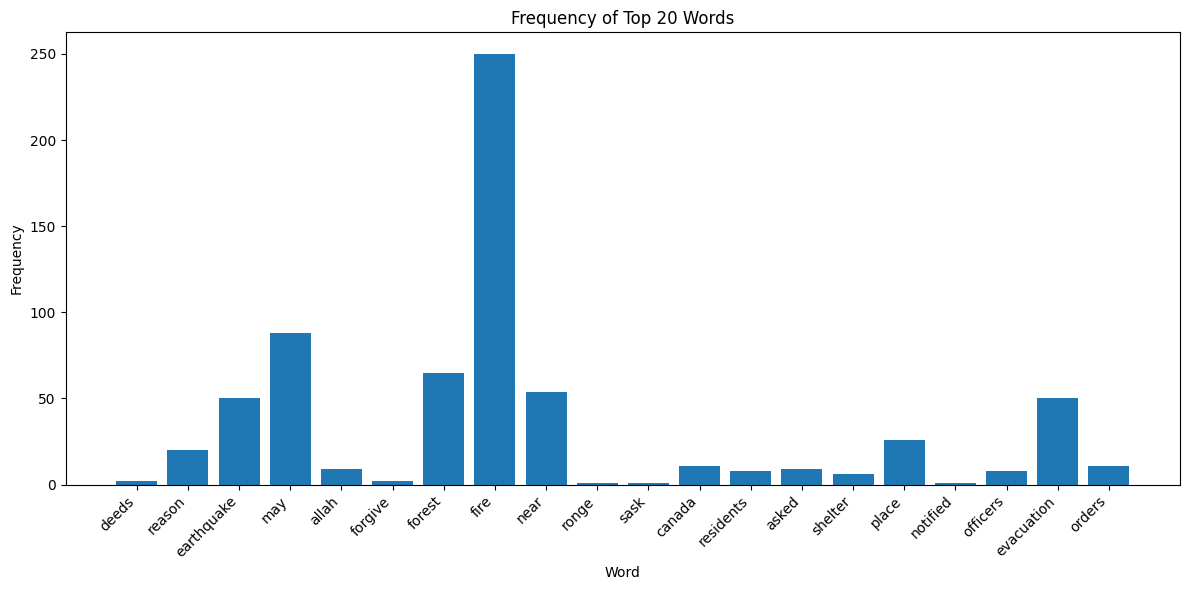

In [56]:
# TODO 5: Vocabulary analysis and optimization
# Your implementation here
import matplotlib.pyplot as plt

total_vocab_size = len(vocab_dict)
print(f"Total vocabulary size: {total_vocab_size}")

# Most common words
most_common_words = count_words.most_common(20)
print(f"Most common words: {most_common_words}")

# Least common words
least_common_words = count_words.most_common()[-20:]
print(f"Least common words: {least_common_words}")

# Word frequency distribution
word_freq = count_words.values()
print(f"Word frequency distribution: {word_freq}")

# Vocabulary coverage
coverage = (len(vocab_dict) / total_vocab_size) * 100
print(f"Vocabulary coverage: {coverage:.2f}%")

# Plot frequency of top 20 words
plt.figure(figsize=(12, 6))
# If count_words is a dict, extract keys (words) and values (frequencies)
top_words = list(count_words.keys())[:20]
top_freqs = list(count_words.values())[:20]
plt.bar(top_words, top_freqs)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 20 Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [61]:
# Based on Zipf's law, the frequency of the most common word is inversely proportional to its rank.
# This means that the most common word appears twice as often as the second most common word,
# three times as often as the third most common word, and so on.
# This is a property of many natural languages and is known as Zipf's law.

# To get rid of words that appear too frequently, we can set a threshold for the frequency.

# Option 1: Keep words with frequency >= 5
min_freq = 4
vocab_dict = {"<PAD>": 0, "<UNK>": 1}
for word, freq in count_words.most_common():
    if freq >= min_freq:
        vocab_dict[word] = len(vocab_dict)

print(f"Vocabulary size after filtering: {len(vocab_dict)}")

Vocabulary size after filtering: 3160


In [64]:
import json

# Save essential vocabulary info for future reproducibility and use:
# This includes vocab size, padding/index conventions, and the most common words.
# Storing this metadata enables consistent preprocessing at inference time,
# as well as easier debugging and model sharing.
import pickle

# Save vocabulary dictionary
with open('../data/processed/vocab_dict.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)
    
print(f"Vocabulary saved! Size: {len(vocab_dict)}")

vocab_info = {
    'vocab_size': len(vocab_dict),             # Number of words in filtered vocabulary
    'max_seq_length': 50,                      # Chosen maximum sequence length for model input
    'pad_idx': 0,                              # Index used for padding tokens in model input
    'unk_idx': 1,                              # Index used for unknown/out-of-vocabulary words
    'most_common_words': list(vocab_dict.keys())[:20],   # Top 20 most frequent words
    'date_created': str(pd.Timestamp.now())    # Timestamp for tracking when vocab was built
}

# Write the vocabulary info dict to a JSON file for reproducibility and reuse later.
# This is needed so downstream scripts/models can load preprocessing settings
# and ensure that the data pipeline remains consistent.
with open('../data/processed/vocab_info.json', 'w') as f:
    json.dump(vocab_info, f, indent=2)

Vocabulary saved! Size: 3160


## TODO 6: Data Pipeline Testing and Validation

**Goal**: Validate the complete data pipeline before moving to modeling

**Steps**:
1. Test data loading with sample batches
2. Verify tensor shapes and data types
3. Check for any data inconsistencies
4. Measure data loading performance
5. Document pipeline characteristics

**Hint**: Use `torch.utils.data.DataLoader` with `num_workers` for efficiency

**Expected Output**: Validated data pipeline ready for model training

---

## Phase 2: Transformers Enhancement

*After completing Phase 1, consider these enhancements:*

- Use HuggingFace tokenizers for consistent tokenization
- Leverage pre-trained vocabularies (BERT, RoBERTa)
- Compare custom vocabulary vs. pre-trained tokenizers
- Analyze vocabulary size impact on model performance


In [62]:
# TODO 6: Data pipeline testing and validation
# Your implementation here
# Test the data pipeline with a sample batch
# Get a batch from the train_loader
import time

batch_texts, batch_labels = next(iter(train_loader))

# Print the shapes of the tensors
print(f"Batch texts shape: {batch_texts.shape}")
print(f"Batch labels shape: {batch_labels.shape}")

# Check data inconsistencies
print(f"Batch labels: {batch_labels}")
print(f"Batch texts: {batch_texts}")

# Measure data loading performance
start_time = time.time()

# Get the next batch
batch_texts, batch_labels = next(iter(train_loader))

# Print the shapes of the tensors
print(f"Batch texts shape: {batch_texts.shape}")
print(f"Batch labels shape: {batch_labels.shape}")

# Measure the time taken to load the batch
end_time = time.time()
print(f"Time taken to load batch: {end_time - start_time:.4f} seconds")

# Check data types
print(f"Batch texts type: {batch_texts.dtype}")


Batch texts shape: torch.Size([32, 50])
Batch labels shape: torch.Size([32])
Batch labels: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1])
Batch texts: tensor([[ 658,  184, 1845,  ...,    0,    0,    0],
        [1980, 1607, 1153,  ...,    0,    0,    0],
        [ 420,  492, 1838,  ...,    0,    0,    0],
        ...,
        [  97,   47,    1,  ...,    0,    0,    0],
        [   1,  249, 1615,  ...,    0,    0,    0],
        [ 528,   21,   62,  ...,    0,    0,    0]])
Batch texts shape: torch.Size([32, 50])
Batch labels shape: torch.Size([32])
Time taken to load batch: 0.0082 seconds
Batch texts type: torch.int64
